Compare new data versus original training data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA

In [18]:
from pptoolbox.preprocessing import SNV, SavitzkyGolay

# import data

In [19]:
parent_dir = Path('../data/processed')
version = 'cinnamon_v5'

data_dir = parent_dir / version

full_dir = data_dir / 'full'

In [20]:
X_full = pd.read_csv(full_dir / 'input.csv', index_col=0)
y_full = pd.read_csv(full_dir / 'label.csv', index_col=0)
meta_full = pd.read_csv(full_dir / 'meta.csv', index_col=0)

In [21]:
complete_idx = set(X_full.index).intersection(set(y_full.index)).intersection(set(meta_full.index))
len(complete_idx)

34

In [22]:
X_full = X_full[X_full.index.isin(complete_idx)]
y_full = y_full[y_full.index.isin(complete_idx)]
meta_full = meta_full[meta_full.index.isin(complete_idx)]

assert X_full.index.equals(y_full.index)
assert X_full.index.equals(meta_full.index)

In [23]:
meta_full.value_counts('date_scanned')

date_scanned
2025-12-22    98
2025-12-01    84
2025-12-02    56
Name: count, dtype: int64

In [24]:
y_full['Batch'] = np.where(meta_full['date_scanned'] < '2025-12-22', 'Batch 1', 'Batch 2')

In [25]:
y_full

,Origin,Variety,Batch
lot_id,,,
111502,Sri Lanka,Cinnamon,Batch 1
111502,Sri Lanka,Cinnamon,Batch 1
111502,Sri Lanka,Cinnamon,Batch 1
111502,Sri Lanka,Cinnamon,Batch 1
111502,Sri Lanka,Cinnamon,Batch 1
...,...,...,...
115040,China,Cassia,Batch 2
115040,China,Cassia,Batch 2
115040,China,Cassia,Batch 2


# preprocessing

In [26]:
def apply_preprocessing(X, prepro_method):
    """
    Apply preprocessing to spectral data.
    
    Parameters:
    -----------
    X : pd.DataFrame
    prepro_method : str
        One of: 'NoPrepro', 'SNV', 'SG1D'
    
    Returns:
    --------
    dict : Contains X_plot and prepro name
    """
    
    if prepro_method == 'NoPrepro':
        return {
            'X_plot': X.copy(),
            'prepro': 'NoPrepro'
        }
    
    elif prepro_method == 'SNV':
        return {
            'X_plot': pd.DataFrame(SNV().fit_transform(X), index=X.index, columns=X.columns),
            'prepro': 'SNV'
        }
    
    elif prepro_method == 'SG1D':
        msc = SavitzkyGolay(deriv=1, window=9, polyorder=2)
        return {
            'X_plot': pd.DataFrame(msc.fit_transform(X), 
                                columns=X.columns[4:-4], index=X.index),
            'prepro': 'SG1D'
        }
    
    else:
        raise ValueError(f"Unknown preprocessing method: {prepro_method}")


# Loop through all preprocessing methods
prepro_methods = ['NoPrepro', 'SNV', 'SG1D']
prepro_results = {}

for method in prepro_methods:
    prepro_results[method] = apply_preprocessing(X_full, method)
    print(f"✓ Applied {method} preprocessing")

✓ Applied NoPrepro preprocessing
✓ Applied SNV preprocessing
✓ Applied SG1D preprocessing


# plotting

In [27]:
viz_output_dir = full_dir / 'visualizations'
viz_output_dir.mkdir(parents=True, exist_ok=True)

In [32]:
for prepro_method in prepro_methods:
    print(f"Plotting PCA for {prepro_method} preprocessing...")

    # Get preprocessed data
    prepro_data = prepro_results[prepro_method]
    X_full_plot = prepro_data['X_plot']
    prepro = prepro_data['prepro']

    X_pca = {}

    for label in [
        'Origin',
        'Variety',
        'Batch'
    ]:
        pca_full = PCA()
        X_pca_full = pca_full.fit_transform(X_full_plot)
        explained_variance_full = np.cumsum(pca_full.explained_variance_ratio_)
        n_components_full = np.argmax(explained_variance_full >= 0.99) + 1

        pca = PCA(n_components=n_components_full)
        X_pca[label] = pd.DataFrame(
            pca.fit_transform(X_full_plot),
            index=X_full_plot.index,
            columns=[f'PC{i+1}' for i in range(n_components_full)]
        )

        # Limit to first 6 components for pairplot readability
        n_components_plot = min(X_pca[label].shape[1], 6)
        pc_columns = [f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})' 
                    for i in range(n_components_plot)]
        
        pc_df = X_pca[label].iloc[:, :n_components_plot].copy()
        pc_df.columns = pc_columns
        pc_df = pd.concat([pc_df, y_full[label]], axis=1)

        g = sns.pairplot(
            pc_df,
            hue=label,
            diag_kind='kde',
            plot_kws={'alpha': 0.7, 's': 40},
            diag_kws={'fill': True}
        )
        g.fig.suptitle(f'PCA | {prepro} | {label}', y=1.02)
        
        viz_output_dir = full_dir / 'visualizations'
        viz_output_dir.mkdir(parents=True, exist_ok=True)

        plot_filename = viz_output_dir / f'PCA_{prepro}_{label}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.close()

Plotting PCA for NoPrepro preprocessing...


c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Plotting PCA for SNV preprocessing...


c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Plotting PCA for SG1D preprocessing...


c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\RyanSoh\miniconda3\envs\py312pp133\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


# hierarchical clustering

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def hierarchical_clustering(X, labels=None, method='ward', metric='euclidean', 
                           figsize=(14, 8), title='Hierarchical Clustering Dendrogram'):
    """
    Perform hierarchical clustering and plot dendrogram.
    Each row in X becomes a node in the dendrogram.
    
    Parameters:
    -----------
    X : array-like or DataFrame
        Input data (n_samples, n_features)
    labels : array-like, optional
        Sample labels for dendrogram leaf labels. If None and X is a DataFrame, uses X.index
    method : str, default='ward'
        Linkage method ('ward', 'complete', 'average', 'single')
    metric : str, default='euclidean'
        Distance metric ('euclidean', 'cosine', 'correlation', etc.)
    figsize : tuple, default=(14, 8)
        Figure size
    title : str
        Plot title
    
    Returns:
    --------
    Z : ndarray
        Linkage matrix
    fig : matplotlib figure
        The generated figure
    """
    
    # Use DataFrame index as labels if not provided
    if labels is None and hasattr(X, 'index'):
        labels = X.index.astype(str).tolist()
    
    # Compute linkage matrix (rows are samples/nodes)
    Z = linkage(X, method=method, metric=metric)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot dendrogram
    dendrogram(Z, 
               labels=labels,
               ax=ax,
               leaf_font_size=8,
               leaf_rotation=90)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Sample', fontsize=12)
    ax.set_ylabel('Distance', fontsize=12)
    
    plt.tight_layout()
    
    return Z, fig

In [47]:
meta_full['lot_name_root'] = meta_full['lot_name'].str.split('a').str[0]

mask = (y_full['Batch'] == 'Batch 1') & (~meta_full['lot_name_root'].str.contains('b'))

X_masked = X_full[mask]
y_masked = y_full[mask]
meta_masked = meta_full[mask]

In [48]:
y_masked_lot = y_masked[~y_masked.index.duplicated(keep='first')]
meta_masked_lot = meta_masked[~meta_masked.index.duplicated(keep='first')]

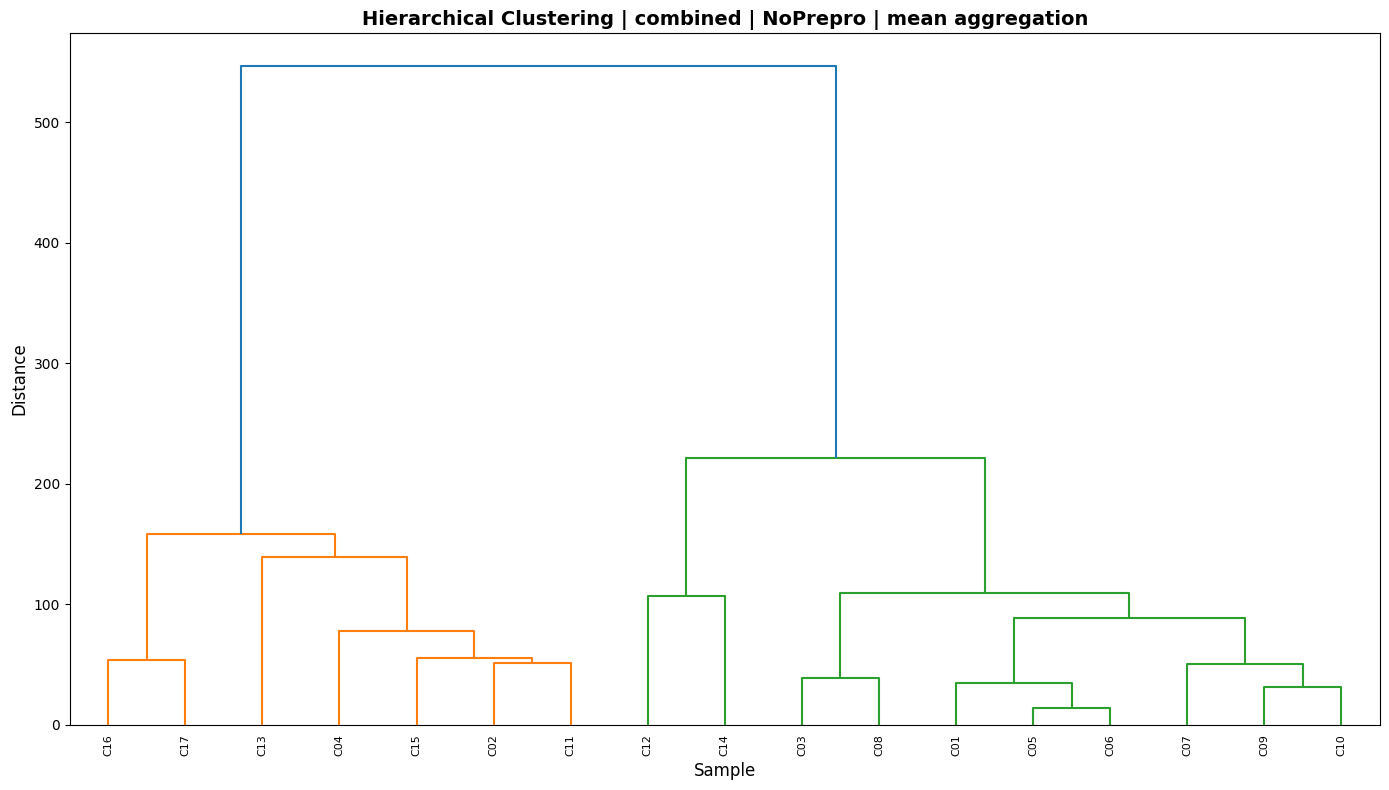

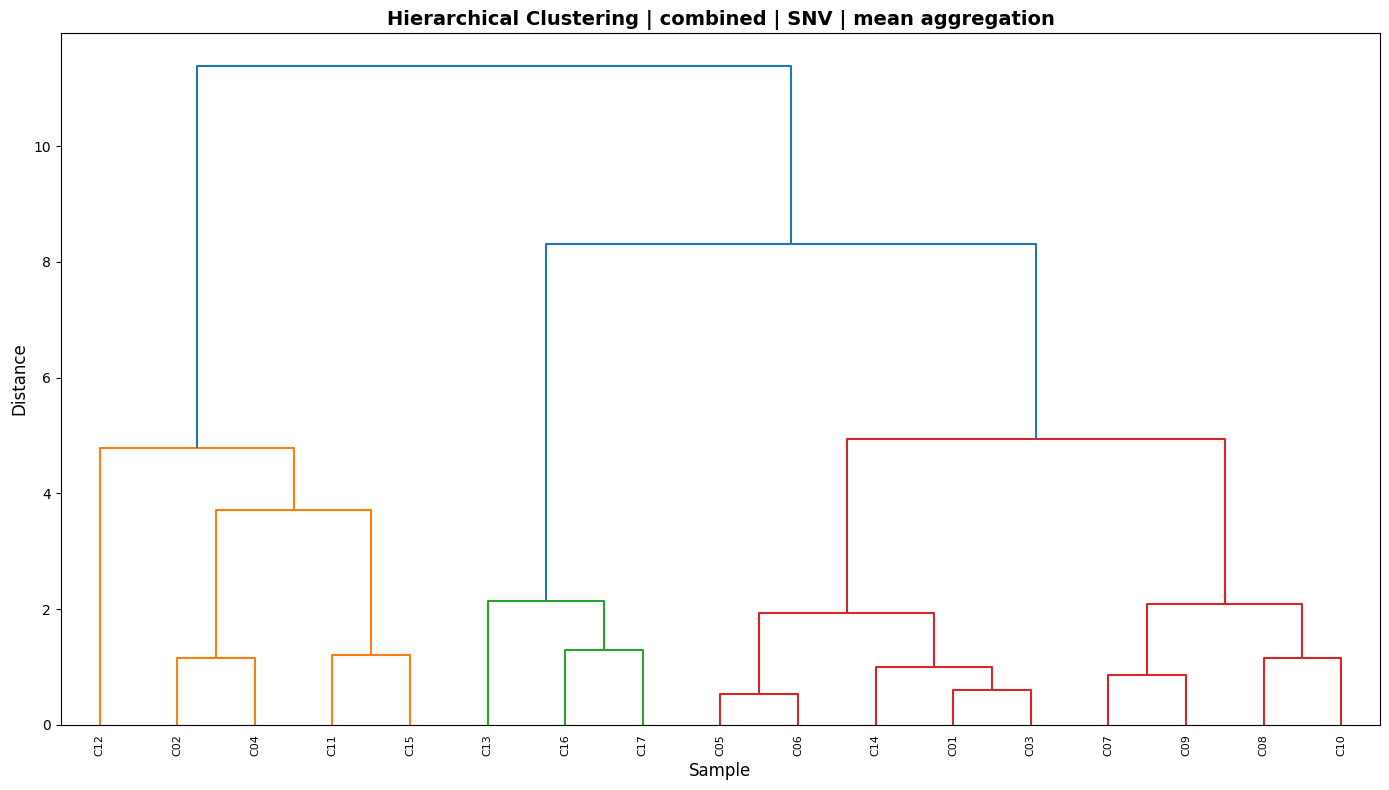

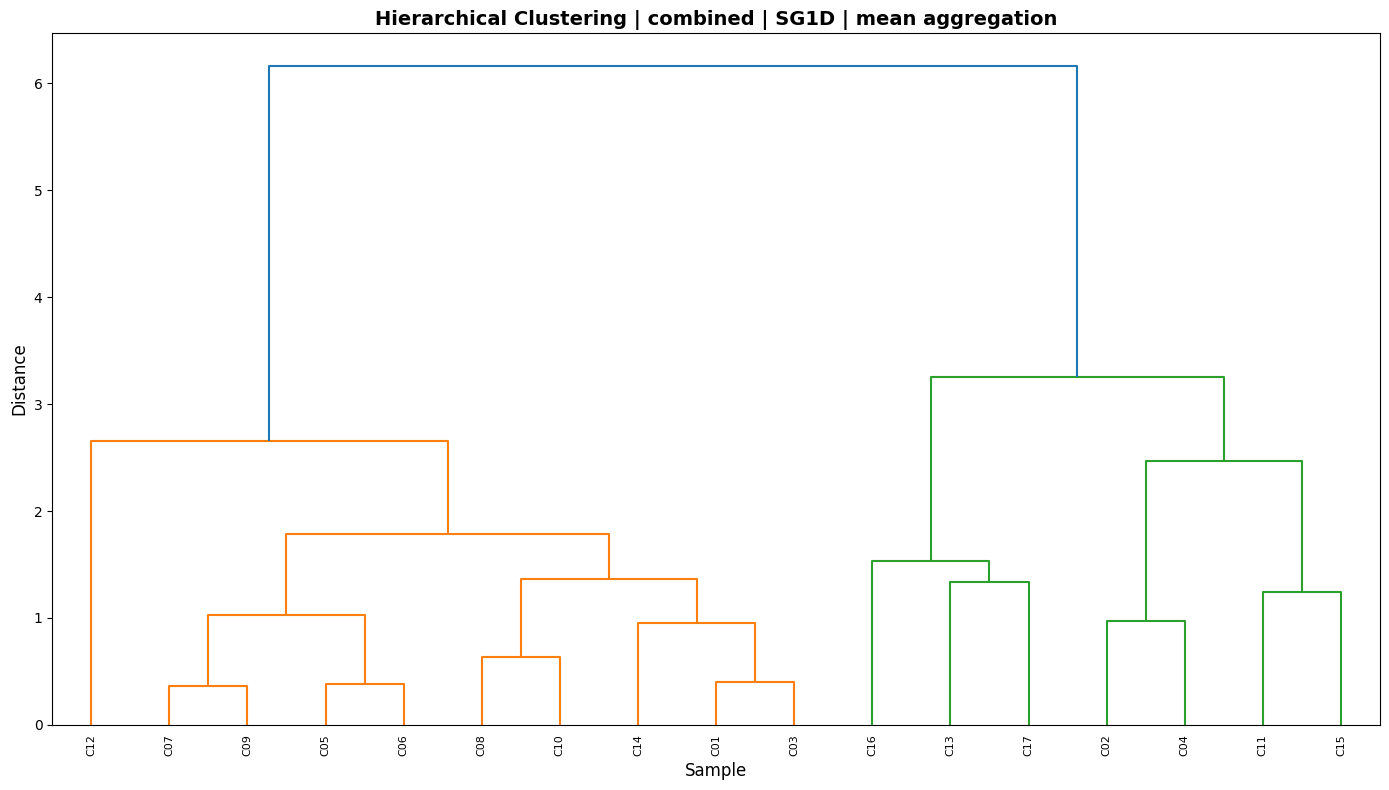

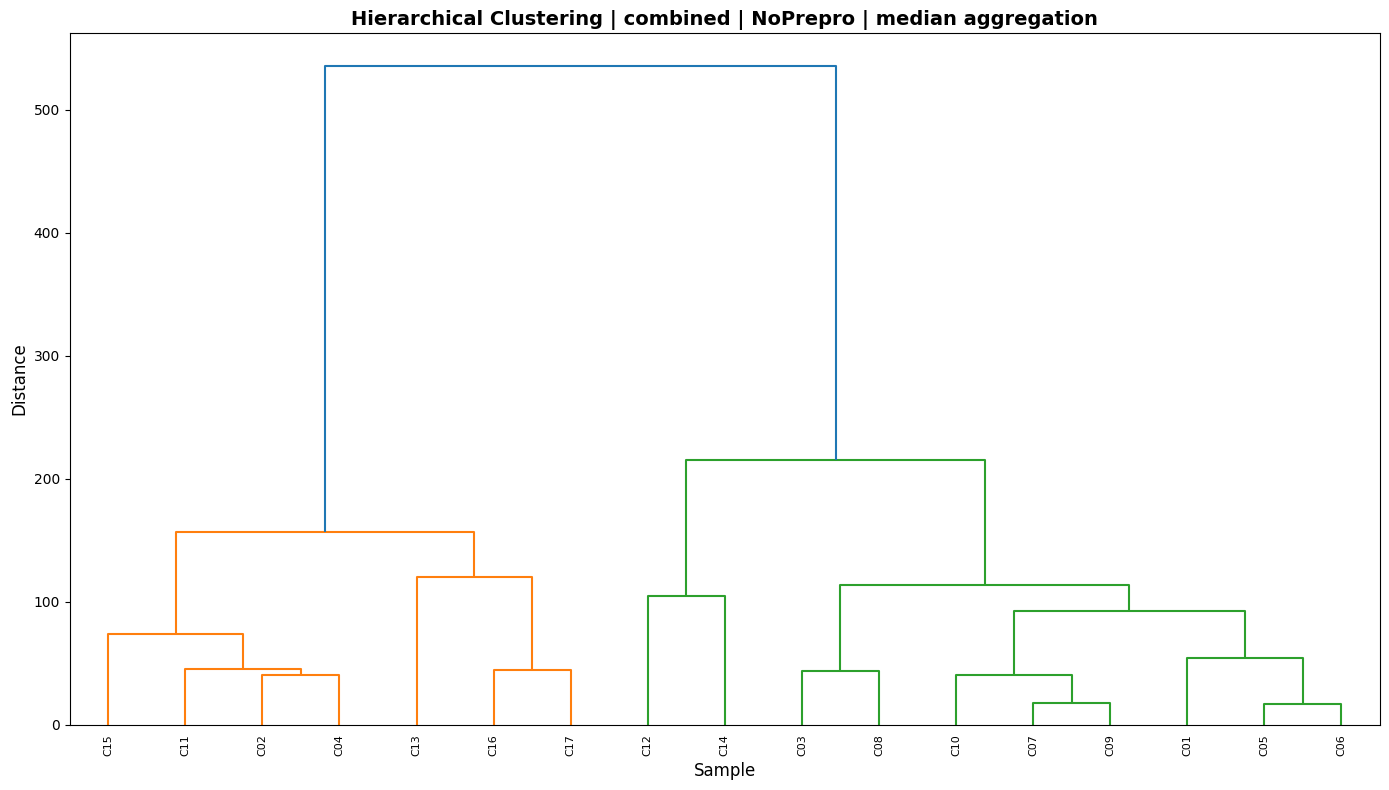

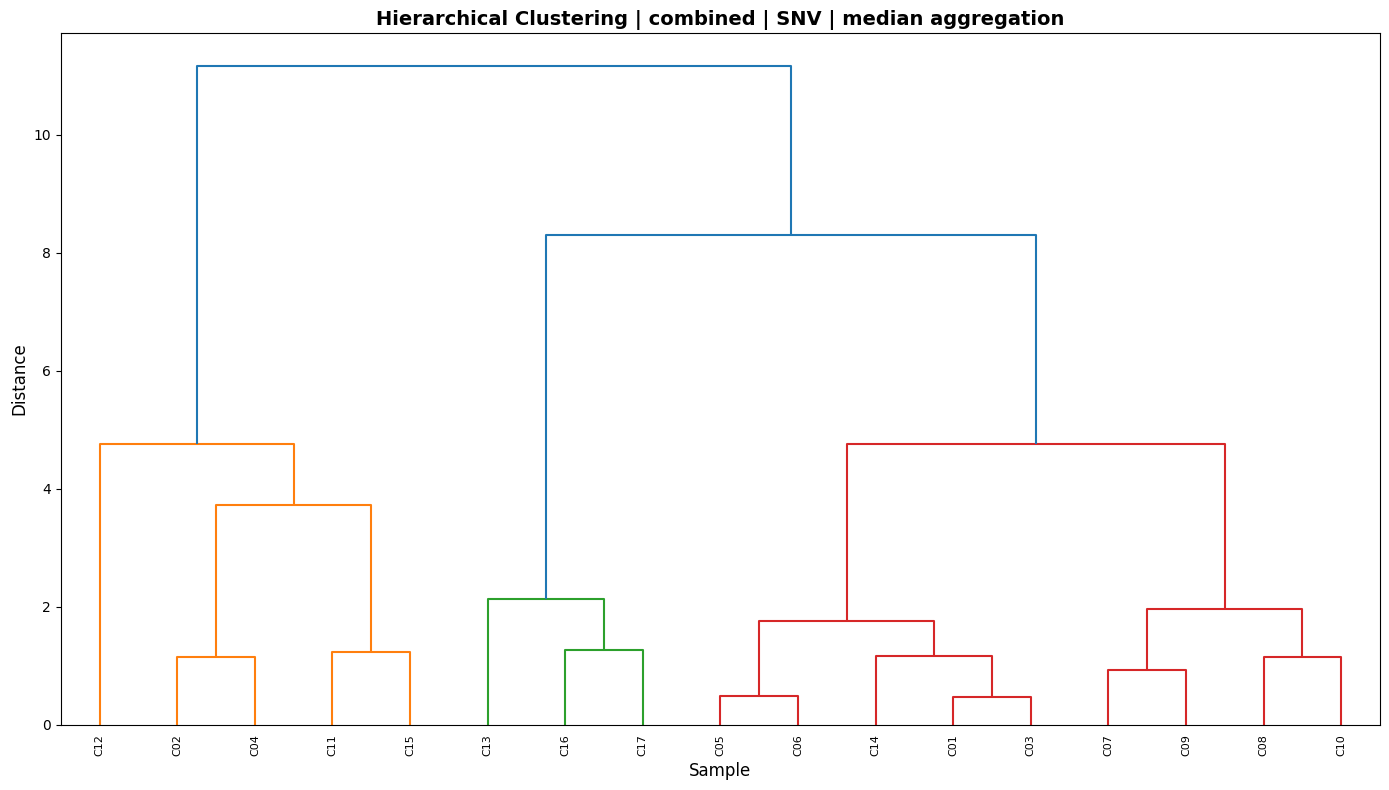

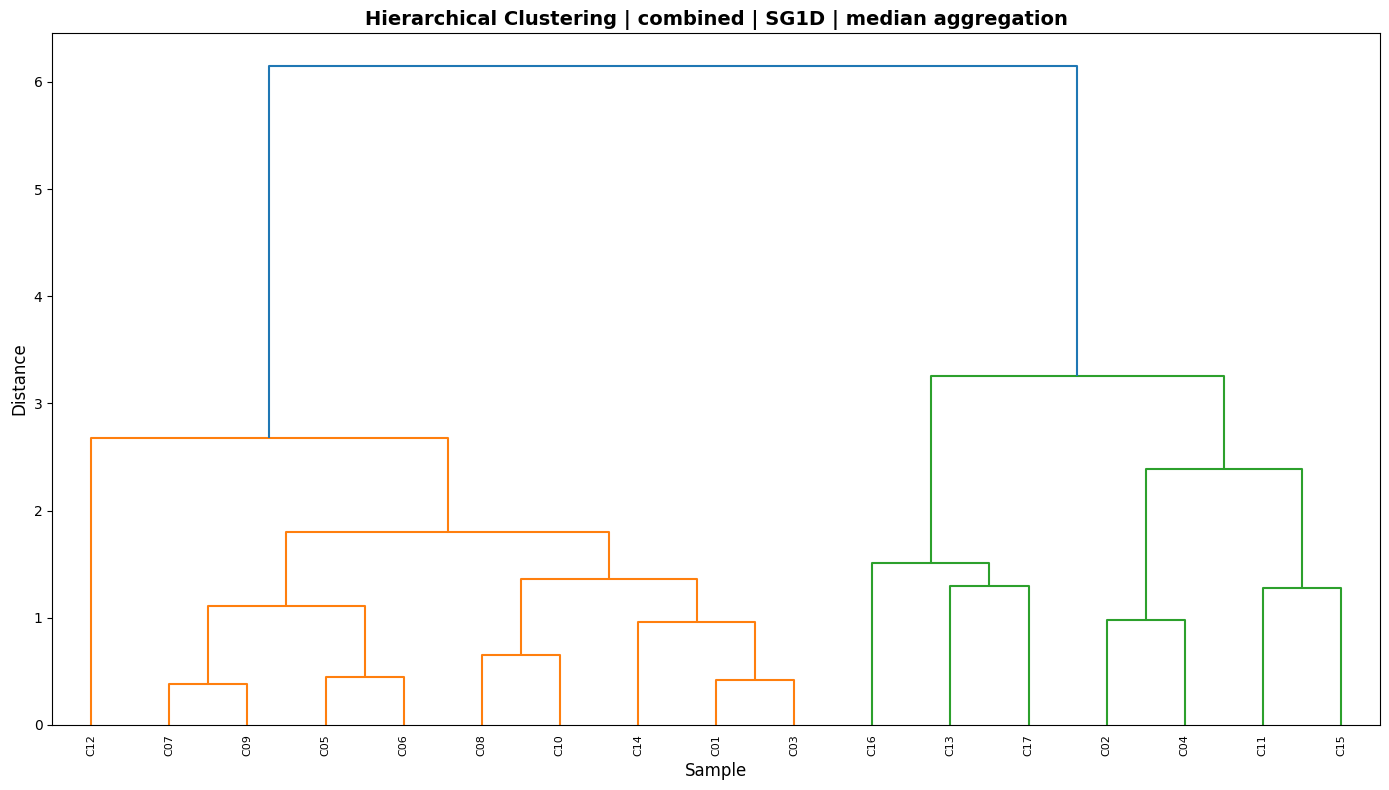

In [57]:
# Loop through all preprocessing methods for hierarchical clustering
for name, agg_method in zip(['mean','median'], [np.mean, np.median]):
    for prepro_method in prepro_methods:
        # Get preprocessed data
        prepro_data = prepro_results[prepro_method]
        X_full_plot = prepro_data['X_plot']
        prepro = prepro_data['prepro']

        X_masked = X_full_plot[mask]
        X_masked_lot = X_masked.groupby(X_masked.index).agg(agg_method)


        Z, fig = hierarchical_clustering(X_masked_lot, labels = meta_masked_lot['lot_name_root'].to_list(), 
                                        title=f'Hierarchical Clustering | combined | {prepro} | {name} aggregation')
        plt.show()
        fig.savefig(viz_output_dir / f'Hierarchical_Clustering_combined_{prepro}_{name}.png', dpi=300, bbox_inches='tight')
        plt.close()